#### Load packages

In [1]:
# data analysis stack
import numpy as np
import pandas as pd

# data visualization stack
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

# miscellaneous
import scipy
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# deep learning stack
import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras.preprocessing import image

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
# tensorflow and keras version
print(f'TensorFlow version: {tf.__version__}')
print(f'Keras version: {keras.__version__}')

TensorFlow version: 2.5.0
Keras version: 2.5.0


**Load model**

In [3]:
# mobilenet_v2
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

**User-defined functions**

In [4]:
def image_resizing(image_path):
    """
    This function resizes an input image to 224 X 224
    """
    img = image.load_img(image_path, target_size=(224,224))
    return img

In [5]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
 
def image_preprocessing(resized_image):
    """
    This function preprocesses the input image for MobileNetV2
    """
    pic_array = image.img_to_array(resized_image)
    image_batch = np.expand_dims(pic_array, axis=0)
    processed_image = preprocess_input(image_batch)
    return processed_image

In [6]:
from tensorflow.keras.applications.mobilenet_v2 import decode_predictions

def image_class_prediction(model, preprocessed_image):
    """
    This function spits out the top-5 predictions 
    for a given model with a proprocessed image
    """
    model_prediction = model.predict(preprocessed_image,verbose=0)
    decoded_prediction = decode_predictions(model_prediction,top=5)[0]
    data = {'image_class': [_[1] for _ in decoded_prediction],
            'probability': [_[2] for _ in decoded_prediction]
           }
    df = pd.DataFrame(data=data)
    return df

**Instantiate model**

In [7]:
pretrained_model = MobileNetV2(weights='imagenet')

Metal device set to: Apple M1 Pro


**Model summary**

In [8]:
pretrained_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

**Model evaluation**

In [9]:
# resize and show image
#resized_image = image_resizing('test_images/phone_1.png')
#resized_image

In [10]:
# preprocess an image
#preprocessed_img = image_preprocessing(resized_image)

# class prediction
#image_class_prediction(pretrained_model, preprocessed_img)

############################################################################################################################
############################################################################################################################

## 3. Transfer Learning Example

**Getting new training images into keras**

In [17]:
# this are the folder names
classes = os.listdir('/Users/ivandominguez/Desktop/Spiced_Academy/spiced_projects/week_09/train_images')
classes = classes[-4:]
classes

['Oranges', 'Apples', 'Kiwis', 'Pears']

In [18]:
# define an image data generator
data_gen = keras.preprocessing.image.ImageDataGenerator(
    # define the preprocessing function to be applied to all images
    preprocessing_function=preprocess_input
)

In [19]:
# a generator that returns batches of X and y arrays
train_data_gen = data_gen.flow_from_directory(
        directory='./train_images',
        class_mode="categorical",
        classes=classes,
        batch_size=300,
        target_size=(224, 224)
)

Found 678 images belonging to 4 classes.


In [20]:
# load in all images at once
xtrain, ytrain = next(train_data_gen)
xtrain.shape, ytrain.shape

((300, 224, 224, 3), (300, 4))

### 3.1 Model Building 

**3.1.1 Select the convolutional base and freeze the weights**

In [21]:
base_model = MobileNetV2(
    weights='imagenet', 
    alpha=1.0,         # specific parameter of this model, small alpha reduces the number of overall weights
    pooling='avg',      # applies global average pooling to the output of the last conv layer (like a flattening)
    include_top=False,  # we only want to have the base, not the final dense layers 
    input_shape=(224, 224, 3)
)

# freeze it!
base_model.trainable = False

In [22]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

**3.1.2 Add dense layers on top**

In [23]:
def model_builder(hp):
    '''
    Args:
    hp - Keras tuner object
    '''
    # Initialize the Sequential API and start stacking the layers
    model = keras.Sequential()
    model.add(base_model)
    
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-160
    hp_units = hp.Int('units', min_value=32, max_value=160, step=32)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    
    # Add next layers
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(len(classes), activation='softmax'))
    
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
              loss=keras.losses.categorical_crossentropy,
              metrics=[keras.metrics.categorical_accuracy])

    return model

### 3.2 Hyperparameter Tuning

In [24]:
# Instantiate the tuner
tuner = kt.Hyperband(model_builder, # the hypermodel
                     objective='val_categorical_accuracy', # objective to optimize
                     max_epochs=50,
                     hyperband_iterations=3,
                     project_name='tuning_results')

In [25]:
# hypertuning settings
tuner.search_space_summary() 

Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 160, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [26]:
# Perform hypertuning
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tf.autograph.experimental.do_not_convert
tuner.search(xtrain, ytrain,
             epochs=50,
             batch_size=16,
             callbacks=[stop_early],
             validation_split=1/6)

Trial 15 Complete [00h 00m 04s]
val_categorical_accuracy: 0.9599999785423279

Best val_categorical_accuracy So Far: 1.0
Total elapsed time: 00h 01m 07s
INFO:tensorflow:Oracle triggered exit


In [27]:
# best hyperparameters
best_hp=tuner.get_best_hyperparameters(1)[0]

In [28]:
# Build the model with the optimal hyperparameters
h_model = tuner.hypermodel.build(best_hp)
h_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
dense_2 (Dense)              (None, 64)                81984     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
Total params: 2,340,228
Trainable params: 82,244
Non-trainable params: 2,257,984
_________________________________________________________________


### 3.3 Model Training

In [29]:
tf.autograph.experimental.do_not_convert
h_model.fit(xtrain, ytrain,
            epochs=50,
            batch_size=16,
            callbacks=[stop_early],
            validation_split=1/6)

Epoch 1/50
16/16 [==============================] - 4s 167ms/step - loss: 0.8692 - categorical_accuracy: 0.6560 - val_loss: 0.1962 - val_categorical_accuracy: 0.9600
Epoch 2/50
16/16 [==============================] - 1s 54ms/step - loss: 0.2821 - categorical_accuracy: 0.9200 - val_loss: 0.0860 - val_categorical_accuracy: 0.9600
Epoch 3/50
16/16 [==============================] - 1s 50ms/step - loss: 0.1416 - categorical_accuracy: 0.9680 - val_loss: 0.0681 - val_categorical_accuracy: 0.9800
Epoch 4/50
16/16 [==============================] - 1s 52ms/step - loss: 0.0724 - categorical_accuracy: 0.9840 - val_loss: 0.0420 - val_categorical_accuracy: 0.9800
Epoch 5/50
16/16 [==============================] - 1s 48ms/step - loss: 0.0652 - categorical_accuracy: 0.9880 - val_loss: 0.0330 - val_categorical_accuracy: 0.9800
Epoch 6/50
16/16 [==============================] - 1s 48ms/step - loss: 0.0346 - categorical_accuracy: 1.0000 - val_loss: 0.0202 - val_categorical_accuracy: 1.0000
Epoch 7/5

In [30]:
losses = pd.DataFrame(h_model.history.history) # losses in the training history
epoch = losses.index.values+np.ones_like(losses.index.values) # epoch number
loss = losses['loss'].values # training loss
val_loss = losses['val_loss'].values # validation loss

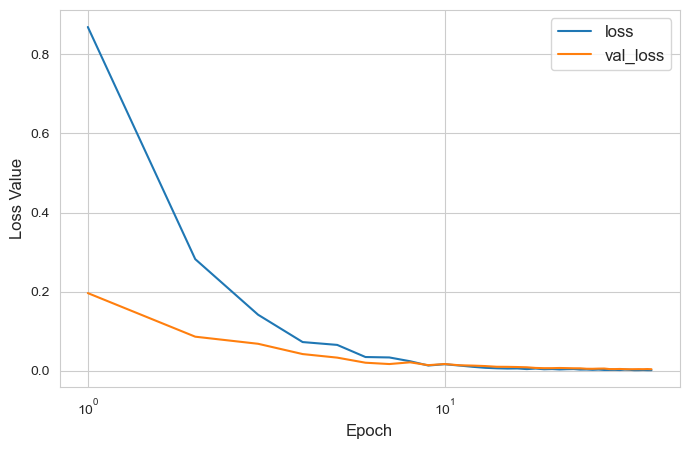

In [31]:
# plot losses against epoch number in log-scale
plt.figure(figsize=(8,5),dpi=100)
plt.semilogx(epoch, loss, linewidth=1.5, label='loss')
plt.semilogx(epoch, val_loss, linewidth=1.5, label='val_loss')
plt.xlabel('Epoch',fontsize=12)
plt.ylabel('Loss Value',fontsize=12)
plt.legend(loc=1,fontsize=12)
None

### 3.4 Model Evaluation

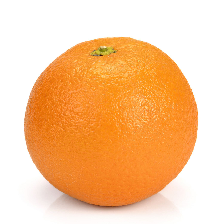

In [32]:
# resize and show image
resized_image = image_resizing('/Users/ivandominguez/Desktop/Spiced_Academy/spiced_projects/week_09/test_images/6000191272346_R.jpeg')
resized_image

In [33]:
# preprocess an image
preprocessed_img = image_preprocessing(resized_image)

In [34]:
def image_classification(preprocessed_image, model):
    probs = model.predict(preprocessed_image)[0].tolist()
    zipped = sorted(list(zip(classes, probs)), key=lambda x: x[1], reverse=True)
    image_class = [zipped[i][0] for i in range(len(zipped))]
    probability  = [zipped[i][1]*100 for i in range(len(zipped))]
    df = pd.DataFrame(data={'image_class':image_class, 'probability(%)': probability})
    return df

In [35]:
tf.autograph.experimental.do_not_convert
image_classification(preprocessed_img, h_model)

,image_class,probability(%)
0,Oranges,99.934500
1,Apples,0.054643
2,Kiwis,0.010787
3,Pears,0.000074


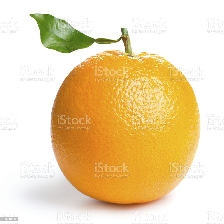

In [36]:
# resize and show image
resized_image = image_resizing('/Users/ivandominguez/Desktop/Spiced_Academy/spiced_projects/week_09/test_images/istockphoto-185284489-1024x1024.jpeg')
resized_image

In [37]:
# preprocess an image
preprocessed_img = image_preprocessing(resized_image)

In [38]:
def image_classification(preprocessed_image, model):
    probs = model.predict(preprocessed_image)[0].tolist()
    zipped = sorted(list(zip(classes, probs)), key=lambda x: x[1], reverse=True)
    image_class = [zipped[i][0] for i in range(len(zipped))]
    probability  = [zipped[i][1]*100 for i in range(len(zipped))]
    df = pd.DataFrame(data={'image_class':image_class, 'probability(%)': probability})
    return df

In [39]:
tf.autograph.experimental.do_not_convert
image_classification(preprocessed_img, h_model)

,image_class,probability(%)
0,Oranges,99.670154
1,Apples,0.317988
2,Kiwis,0.008200
3,Pears,0.003659


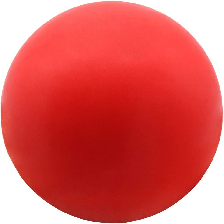

In [40]:
# resize and show image
resized_image = image_resizing('/Users/ivandominguez/Desktop/Spiced_Academy/spiced_projects/week_09/test_images/51Ne0QiK9PL._AC_SL1001_.jpg')
resized_image

In [41]:
# preprocess an image
preprocessed_img = image_preprocessing(resized_image)

In [42]:
def image_classification(preprocessed_image, model):
    probs = model.predict(preprocessed_image)[0].tolist()
    zipped = sorted(list(zip(classes, probs)), key=lambda x: x[1], reverse=True)
    image_class = [zipped[i][0] for i in range(len(zipped))]
    probability  = [zipped[i][1]*100 for i in range(len(zipped))]
    df = pd.DataFrame(data={'image_class':image_class, 'probability(%)': probability})
    return df

In [43]:
tf.autograph.experimental.do_not_convert
image_classification(preprocessed_img, h_model)

,image_class,probability(%)
0,Apples,99.974579
1,Oranges,0.024906
2,Kiwis,0.000489
3,Pears,0.000018
